# A/B Testing on Marketing Data

##### The dataset consists of control and exposed group of users who chose/not chose to respond to the BIO Questionnaire presented in two different forms. We are trying to understand what experiment worked best for the company using Sampling Distribution under the null hypothesis.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [2]:
#Importing libraries for A/B Testing
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [3]:
data=pd.read_csv('Adsmart_data.csv')

In [4]:
data.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   auction_id   8077 non-null   object
 1   experiment   8077 non-null   object
 2   date         8077 non-null   object
 3   hour         8077 non-null   int64 
 4   device_make  8077 non-null   object
 5   platform_os  8077 non-null   int64 
 6   browser      8077 non-null   object
 7   yes          8077 non-null   int64 
 8   no           8077 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 568.0+ KB


In [6]:
len(data['device_make'].unique())

269

In [7]:
print(len(data['platform_os'].unique()))
print(data['platform_os'].unique())

3
[6 5 7]


In [8]:
print(len(data['browser'].unique()))
print(data['browser'].unique())

15
['Chrome Mobile' 'Chrome Mobile WebView' 'Facebook' 'Mobile Safari'
 'Chrome Mobile iOS' 'Samsung Internet' 'Mobile Safari UI/WKWebView'
 'Chrome' 'Opera Mini' 'Edge Mobile' 'Android' 'Pinterest' 'Opera Mobile'
 'Firefox Mobile' 'Puffin']


In [9]:
#range of dates
data=data.sort_values(by='date',ascending=False)
print(data['date'].head(1).values[0])
print(data['date'].tail(1).values[0])

2020-07-10
2020-07-03


**Observation: This experiment was run for 7 days on 8077 people. There are various unique values when it comes to the data of devices and browsers used. We can conduct analysis on the same later in the project.**

In [10]:
#checking for duplicates
if data.iloc[: ,0].nunique() == data.shape[0]:
    print('There are no duplicates')
else:
    print('There are some duplicates')

There are no duplicates


## Analysis

We are interested in the data where the users interacted with the BIO Questionnaire. Thus, I seperated the data into two different groups of controlled and exposed with the data of the users who interacted with the questionnaire.

In [11]:
#How many people interacted with the questionnaire?
result = data.query('yes==0 & no==0')
len(result)
print('Number of people who interacted with the BIO Questionnaire are',len(data)-len(result))

Number of people who interacted with the BIO Questionnaire are 1243


In [12]:
#Among the 1243 people, I will divide the data into two sets: exposed and control
# Filter out users that were not interacting
new_data = data.query('yes==1 | no==1')

# Divide a dataframe by exposed and control group
exposed = new_data.query('experiment == "exposed"')
control = new_data.query('experiment == "control"')

exposed_conversion = '{0:.2f}%'.format(exposed.yes.mean()*100)
control_conversion = '{0:.2f}%'.format(control.yes.mean()*100)

print('Number of people in the exposed group are',len(exposed))
print('among which',exposed_conversion, 'converted')

print('\n')

print('On the other hand')

print('\n')

print('Number of people in the control group are',len(control))
print('among which',control_conversion, 'converted')

Number of people in the exposed group are 657
among which 46.88% converted


On the other hand


Number of people in the control group are 586
among which 45.05% converted


In [14]:
diff = exposed.yes.mean() - control.yes.mean()
diff_1 = '{0:.2f}%'.format(diff*100)
print('The difference between the conversion rates is',diff_1)

The difference between the conversion rates is 1.83%


## Please Find Visualization of variables with the control and exposed group On Tableau

## Formulation of Hypothesis

𝑁𝑢𝑙𝑙 (𝐻0) 𝑎𝑛𝑑 𝐴𝑙𝑡𝑒𝑟𝑛𝑎𝑡𝑖𝑣𝑒 (𝐻1) 𝐻𝑦𝑝𝑜𝑡ℎ𝑒𝑠𝑖𝑠
 
𝐻0: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑=0
 
𝐻1: 𝑌𝑛𝑒𝑤− 𝑌𝑜𝑙𝑑>0

Null hypothesis states that there are no changes in the conversion rate between the two ads. However, the alternative hypothsis states that the conversion rate is higher with the new creative ad (exposed) than the dummy ad (control). Here we are trying to confirm the alternate hypothesis which we believe in.

We will consider the level of significance to be 5%. Let's compare the resulted p value to the significance level to test our hypothesis.

## Sampling Distribution

In [60]:
#storing only yes = 1 in exposed and control groups
exposed_1 = exposed.query('yes == 1')
control_1 = control.query('yes == 1')

In [16]:
#storing number of conversions for exposed and control groups as numpy arrays
count = np.array([exposed_1.shape[0], control_1.shape[0]])
count

array([308, 264])

In [17]:
#storing sample sizes of exposed and control group as numpy arrays
nobs = np.array([exposed.shape[0], control.shape[0]])
nobs

array([657, 586])

In [18]:
#storing results of z test in variables
stat, p_val = proportions_ztest(count, nobs, alternative = 'larger')
p_form = '{0:.2f}%'.format(p_val*100)
print('P-value is =',p_form)

P-value is = 25.92%


**Z-test is used to check whether the means of two populations are equal to each other when the population variance is known. The null hypothesis of a z test can be rejected if the z test statistic is statistically significant when compared with the critical value.**

In [26]:
# Draw 100000 samples from binominal distribution
e_simulation = np.random.binomial(exposed.shape[0], exposed.yes.mean(), 100000)/exposed.shape[0]
c_simulation = np.random.binomial(control.shape[0], control.yes.mean(), 100000)/control.shape[0]
p_diffs = e_simulation - c_simulation
diffs = np.array(p_diffs)

#Creation of normal distribution centered at zero
null_vals = np.random.normal(0, np.std(diffs), len(diffs))
null_vals

array([ 0.060689  ,  0.0217139 , -0.03938923, ...,  0.03229162,
       -0.01078254,  0.02329762])

In [47]:
def statplot(data, lim, obs_stat, title):
    #Create a kdeplot
    plt.figure(figsize=(12,4), tight_layout=True)
    ax = sns.kdeplot(data, linewidth = 0.8, color = 'black')
    
    # Simple formatting
    frame = ['right', 'left', 'top']
    for i in frame:
        ax.spines[i].set_visible(False)

    plt.title(title)
    plt.ylabel('')
    plt.yticks([], [])
    
    # Legend
    line = Line2D([0], [0], color='blue', linestyle = '-', label='observed statistic')
    line_dashed = Line2D([0], [0], color='red', linestyle = '--', label='mean and standard deviation')
    plt.legend(handles=[line, line_dashed], loc='upper left');
    
    # Create a list of 3 standard deviation to the left and to the right and mean
    std_list = []
    std_list_format = []
    for i in range(-3,4):
        std_dev = np.std(data) * i + np.mean(data)
        std_list.append(std_dev)
        std_list_format.append('{0:.3f}'.format(std_dev) + '\n {} std'.format(i))
        
    # Create a list of corresponding y values
    data_x, data_y = ax.lines[0].get_data()
    height = []
    for i in std_list:
        height.append(np.interp(i, data_x, data_y))
        
    # Plotting vertical lines representing std deviations 
    for a, b in zip(std_list, height):
        plt.axvline(a, 0, b/lim, color = 'blue', alpha = 1, linewidth = 0.8, linestyle = '--')
        plt.plot(a, b, marker = 'o', color = 'black')
    
    # Plotting observed statistic
    obs_line_height = np.interp(obs_stat, data_x, data_y)
    plt.axvline(obs_stat, 0, obs_line_height/lim, color = 'yellow', alpha = 1, linewidth = 0.8, linestyle = '-')
    plt.plot(obs_stat, obs_line_height, marker = 'o', color = 'yellow')
            
    # Plotting x ticks
    x_ticks = std_list
    x_labels = std_list_format
    plt.xticks(x_ticks, x_labels)
    plt.ylim(0,lim)

In [48]:
def shading(data, left, right, color):
    #Shading areas
    kde = stats.gaussian_kde(data)
    shade = np.linspace(left, right, 100)
    plt.fill_between(shade, kde(shade), color = color, alpha = 0.5);

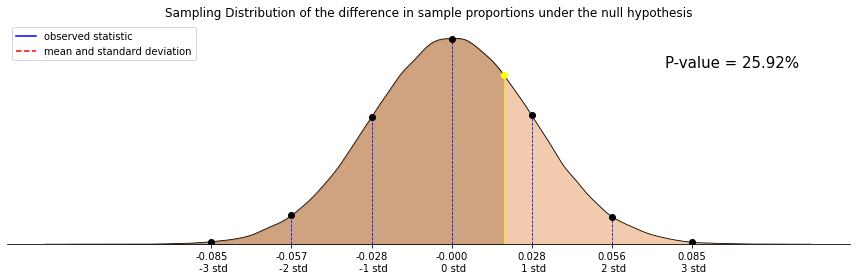

In [54]:
# Plotting the sampling distribution
statplot(null_vals, 15, diff, 'Sampling Distribution of the difference in sample proportions under the null hypothesis')
shading(null_vals, diff, null_vals.max(),'#e6995e')
shading(null_vals, null_vals.min(), diff,'#a14803')
plt.text(0.075, 12, "P-value = {}".format(p_form), color = 'black', size = 15);

**The yellow line indicates the beginning of the conversion rates that falls between the first std deviation. The probability is 25.92% which is way higher than the significance value we chose i.e., 5%. This implies that we fail to reject the null hypothesis and that we do not have enough evidence to conclude that the conversion rate with the new creative as is higher than the dummy ad.**